# Info
(C) convention, for programming standard violation

(R) refactor, for bad code smell

(W) warning, for python specific problems

(E) error, for much probably bugs in the code

(F) fatal, if an error occurred which prevented pylint from doing

[source](https://pylint.pycqa.org/_/downloads/en/pylint-2.1.0/pdf/)

http://pylint-messages.wikidot.com/all-codes

https://pycodequ.al/docs/pylint-messages.html

# Environment configuration

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
palette_color = 'Blues_r'
colors = sns.color_palette(palette_color, as_cmap=True)
sns.set()
pd.set_option('display.max_rows', 100)

/home/ndc/repos/GithubPythonCodeSmellCrawler/src/env/lib/python3.9/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
X0 = 6
Y0 = 4

X1 = 9
Y1 = 6

X2 = 12
Y2 = 9

X3 = 15
Y3 = 12

category_map = {'W':'Warning', 'R':'Refactor','C':'Convention'}

In [3]:
def set_plot_size(w, h):
        rcParams['figure.figsize'] = w, h

def reset_plot_size():
    set_plot_size(X1,Y1)

def make_url(row):
    gh = 'https://github.com/'
    file = row.filename.split('/')[1]
    url = f'{gh}/{row.repo}/tree/{row.commit}/{file}'
    return url

def barplot(d, x, y, **kwargs):
    plot = sns.barplot(data=d,x=x,y=y,ax=kwargs.get('ax'), hue = kwargs.get('hue'))
    plot.set_xlabel(kwargs.get('x_label'))
    plot.set_ylabel(kwargs.get('y_label'))
    plot.set_title(kwargs.get('title'))
    return plot

def violinplot(d, **kwargs):
    plot = sns.violinplot(data=d, cut=0,inner='quartile',ax=kwargs.get('ax'))    
    plot.set_xlabel(kwargs.get('x_label'))
    plot.set_ylabel(kwargs.get('y_label'))
    plot.set_title(kwargs.get('title'))
    return plot

reset_plot_size()

In [4]:
df = pd.read_parquet('data.parquet')
df = df.loc[df.symbol != 'fatal']
df = df.loc[df.linter == 'pylint']
df = df.reset_index(drop=True)

# Data preparation

In [5]:
df.filename = df.filename.apply(lambda x: x.replace('dumps/',''))
df = df.loc[df.type.isin(['W','C','R'])]

## Mark relevant pitfalls

In [6]:
detected_pitfalls = df.number.unique()
all_codes = pd.read_csv('codes.csv')
relevant_codes = all_codes.loc[all_codes.code.isin(detected_pitfalls)]
relevant_codes = relevant_codes.loc[relevant_codes.is_pitfall != 0]

#Lists if an unnanoted pitfall was detected
relevant_codes.loc[relevant_codes.is_pitfall != 1].reset_index(drop=True)

,code,symbol,is_pitfall


In [32]:
new_codes = pd.read_csv('new_codes.csv')
all_codes
new_codes = new_codes.loc[~new_codes.code.isin(all_codes.code)]
new_codes['is_pitfall'] = None
all_codes = pd.concat([all_codes,new_codes])
all_codes = all_codes.sort_values(by='code').reset_index(drop=True)
all_codes.to_csv('')


,code,symbol,is_pitfall
0,C0102,blacklisted-name,NaN
1,C0103,invalid-name,1.0
2,C0104,disallowed-name,0.0
3,C0112,empty-docstring,0.0
4,C0113,unneeded-not,1.0
...,...,...,...
375,W1658,deprecated-urllib-function,NaN
376,W1659,xreadlines-attribute,NaN
377,W1660,deprecated-sys-function,NaN
378,W1661,exception-escape,NaN


In [7]:
relevant_codes = relevant_codes.loc[relevant_codes.is_pitfall == 1].reset_index(drop = True)
relevant_codes.drop(columns = ['is_pitfall']).to_csv('relevant_codes.csv', index=False)

In [8]:
df = df.loc[df.number.isin(relevant_codes.code)].reset_index(drop=True)

In [9]:
#df['url'] = df.apply(make_url, axis=1)
w = df.loc[df.type == 'W']
c = df.loc[df.type == 'C']
r = df.loc[df.type == 'R']

# Data overview

In [10]:
amount_repos = len(df.repo.unique())
print(f'Total of repositories analyzed: {amount_repos}')

Total of repositories analyzed: 143


## Distribution by kind of flaw

## Code counts

[Text(0, 0.0, ''),
 Text(0, 500.0, ''),
 Text(0, 1000.0, ''),
 Text(0, 1500.0, ''),
 Text(0, 2000.0, ''),
 Text(0, 2500.0, ''),
 Text(0, 3000.0, ''),
 Text(0, 3500.0, ''),
 Text(0, 4000.0, '')]

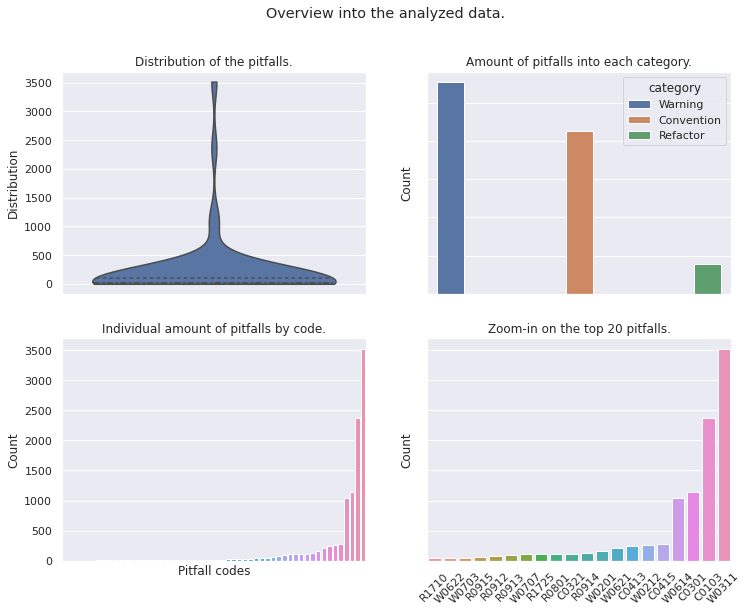

In [11]:
set_plot_size(X2,Y2)

code_counts = df.number.value_counts().reset_index()
code_counts.columns = ['code', 'count']
code_counts = code_counts.sort_values(by='count', ascending=True)
code_counts = code_counts.reset_index(drop=True)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2)


fig.suptitle('Overview into the analyzed data.')
#General violinplot
violinplot(code_counts['count'].values,
           title = 'Distribution of the pitfalls.',
           y_label = 'Distribution',           
           ax = ax0
          )
ax0.set_xticks([])

#Category barplot
category_counts = df.type.value_counts().reset_index()
category_counts.columns = ['category','count']
category_counts.category = category_counts.category.apply(lambda x : category_map[x])
barplot(category_counts,
        x = 'category',
        y = 'count',
        y_label = 'Count',
        title = 'Amount of pitfalls into each category.',
        hue = 'category',
        ax = ax1
       )
ax1.set_yticklabels([])
ax1.set_xticklabels([])

#General barplot
barplot(code_counts,
        x = 'code',
        y_label = 'Count',
        x_label = 'Pitfall codes',
        y = 'count',
        title = 'Individual amount of pitfalls by code.',
        ax=ax2
       )
ax2.set_xticks([])


#Zoom barplot
amount = 20
bigger = code_counts.tail(amount)
right = barplot(bigger,
                x = 'code',
                y = 'count',
                y_label = 'Count',
                title = f'Zoom-in on the top {amount} pitfalls.',
                ax = ax3
               )
ax3.tick_params(axis = 'x', labelrotation = 45 )
ax3.set_yticklabels([])

# Playground